# Comparison Experiments for Deep Time-consistent Elastic Net with Least-angle Regression (deepTENLar) vs 10 Baseline Models for Water Treatment 


## Training + Validating All Models, and Predicting for Shanghai SMI Dataset

In [1]:
import torch
import numpy as np
import torch.nn as nn 
from DataSet import DataSet

# deep
from models import daggerTENLar
from models import deepTENLar
from models import lstmTENLar

from models import ANFIS
import config
import os.path as osp
import pandas as pd
import xlrd
import os
import math
import logging
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, CuDNNLSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_c

In [2]:
class Water:
    def __init__(self, excel_files):
        self.source = DataSet(excel_files)
        
    """ ***************Structure All Model Instances***************"""
    def build_model(self, method, source):
        
        if method== 'daggerTENLar':
            valX = source.dagger_x_test
            valY = source.dagger_y_test
            
            val_dagger_save_metric = []
            daggertenlar_metric = np.zeros([4])
            self.bestScore_dagger = 1000
            
            self.in_features = valX.size(2)
#             self.epoch = 100
            self.epoch = 30
            self.batchSize_train = 128
            self.batchSize_val = 16
            self.trainSeq =  self.seq_abrupt = source.deep_dagger_x.size(1)
            self.testSeq = valX.size(1)
            
            self.Ctime = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
            
            mse_criterion = nn.MSELoss()

            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            daggertenlar = daggerTENLar(self.in_features, self.trainSeq, self.testSeq).cuda().double()
            optimizer_dagger = torch.optim.Adam(daggertenlar.parameters(), lr = 1e-2)
            
            # init loss variable
            loss_dag_save = {}
            loss_dag_sum = 0
            # count clear zero
            count_dag = 0
            
            for i in range(self.epoch):
                
                be_idx = 0
                
                if i==0:
                    trainX_dag = source.deep_dagger_x
                    trainY_dag = source.deep_dagger_y
                else:
                    trainX_dag = source.dagger_shuffle[:,:,:-1]
                    trainY_dag = source.dagger_shuffle[:,:,-1]
                
                while(be_idx + self.batchSize_train) <= (trainX_dag.size(0) - 1):
                    optimizer_dagger.zero_grad()
                    
                    dag_params1 = daggertenlar.parameters()
                    L1_dag_sum = self.sum_params4L(dag_params1, 'L1')
                    
                    dag_params2 = daggertenlar.parameters()
                    L2_dag_sum = self.sum_params4L(dag_params2, 'L2')

#                     print ('L1_dagger_sum_value:', L1_dag_sum)
#                     print ('L2_dagger_sum_value:', L2_dag_sum)
                    
                    ed_idx = be_idx + self.batchSize_train
#                     AD_rate = cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')                    
                    AD_rate = 0.3
                    out = daggertenlar(trainX_dag[be_idx:ed_idx,:,:], trainY_dag[be_idx:ed_idx,:], True)
#                     print ('loss_dagger_slice_1:', mse_criterion(out, trainY_dag[be_idx:ed_idx,:]))
            
                    loss_dag = mse_criterion(out, trainY_dag[be_idx:ed_idx,:]) + lambda1[1] * L1_dag_sum \
                    + lambda2[2] * L2_dag_sum - lambda3[6] * AD_rate * L2_dag_sum
                
#                     print ('dagger_loss:', loss_dag)
                
                    loss_dag.backward()
                    optimizer_dagger.step()
                    loss_dag_sum = loss_dag + loss_dag_sum                    
                    be_idx = ed_idx
                    count_dag = count_dag + 1
                    
                average_dag_loss = loss_dag_sum / count_dag
                epoch_num = 'epoch' + str(i)
                loss_dag_save[epoch_num] = average_dag_loss
                    
                loss_dag_sum = 0
                count_dag = 0
                
#                 print ('Epoch{}:'.format(i))
#                 print ('Average Dagger Loss:', average_dag_loss)                
                    
                ## validation
                if i>=5 and i%5==0:
                    
                    batch_dag_val_b = 0
                    rmse_dag_score_total = 0
                    mape_dag_score_total = 0
                    corr_dag_score_total = 0
                    wi_dag_score_total = 0
                    count_dag_val = 0
                    
                    val_oneBatch_dagger_metric = np.zeros([4])
                    
                    while (batch_dag_val_b + self.batchSize_val) <= valX.size(0):
                        with torch.no_grad():
                            batch_dag_val_e = batch_dag_val_b + self.batchSize_val
                            valXSlice = valX[batch_dag_val_b:batch_dag_val_e,:,:]
                            valYSlice = valY[batch_dag_val_b:batch_dag_val_e]
                            
                            val_dag_out = daggertenlar(valXSlice, valYSlice, False)
                            
                            # calculate metrics for deep
                            rmse_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'rmse')
                            mape_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'mape')
                            corr_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'correlation')
                            wi_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'wi')
                            
                            rmse_dag_score_total = rmse_dag_score_total + rmse_dag_score
                            mape_dag_score_total = mape_dag_score_total + mape_dag_score
                            corr_dag_score_total = corr_dag_score_total + corr_dag_score
                            wi_dag_score_total = wi_dag_score_total + wi_dag_score
                            
                            batch_dag_val_b = batch_dag_val_e
                            count_dag_val = count_dag_val + 1
                            
                    #     
                    val_oneBatch_dagger_metric[0] = rmse_dag_av_score = rmse_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[1] = mape_dag_av_score = mape_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[2] = corr_dag_av_score = corr_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[3] = wi_dag_av_score = wi_dag_score_total / count_dag_val                       
                        
#                     print ('validation{}'.format(round(i / 5)))
#                     print ('RMSE Score_dagger:', rmse_dag_av_score)
#                     print ('MAPE Score_dagger:', mape_dag_av_score)
#                     print ('Correlation Score_dagger:', corr_dag_av_score)
#                     print ('WI Score_dagger:', wi_dag_av_score)
                    
                    if rmse_dag_av_score < self.bestScore_dagger:
                        print ('validation_dagger_best_score:', rmse_dag_av_score)
                        print ('current_best_epoch:', i)
                        
                        val_dagger_save_metric.append(val_oneBatch_dagger_metric)
                        
                          # saving
#                         best_dagger_model_path = os.path.join("./daggertenlar", self.Ctime)                        
#                         if not os.path.exists(best_dagger_model_path):
#                             os.makedirs(best_dagger_model_path)
                        
#                         torch.save(daggertenlar.state_dict(), os.path.join(best_dagger_model_path, "epoch-{}-dagger-rmseScore-{}.pt".format(i, rmse_dag_av_score)))

                        self.bestScore_dagger = rmse_dag_av_score
            # 
            val_save_metric_dagger = np.concatenate(val_dagger_save_metric)
            val_save_metric_dagger = val_save_metric_dagger.reshape(-1, 4)
            
            for i in range(val_save_metric_dagger.shape[1]):
                val_save_metric_dagger_slice = val_save_metric_dagger[:, i]
                val_save_metric_dagger_slice.sort(0)
                
                if i==0 or i==1:
                    daggertenlar_metric[i] = val_save_metric_dagger_slice[0]
                else:
                    daggertenlar_metric[i] = val_save_metric_dagger_slice[-1]
            
            return daggertenlar_metric
                        
                                                  
        if method=='deepTENLar':
            
            # traindata(shuffle) and validation data
            validX = source.deep_x_test
            validY = source.deep_y_test
            
            # save validation(testing) results
            val_save_metric = []
            deeptenlar_metric = np.zeros([4])
            
            # init best_score
            self.best_score = 1000
                       
            # init hyperparameters
            self.in_channels = validX.size(1)
            self.out_channels = 128
            self.kernel_size = 19
            self.stride = 1
            self.padding = 9
#             self.epoch = 150
            self.epoch = 30
            self.batch_size_train = 128
            self.batch_size_val = 10
            self.seq_train =  source.deep_x.size(2)
            self.subpath = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
            

            # selecting best lambda refer to TENLar
            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            # criterion
            mse_criterion = nn.MSELoss()
            
            # init model (per exp_num)
            deeptenlar = deepTENLar(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding).cuda().double()
            optimizer = torch.optim.Adam(deeptenlar.parameters(), lr = 1e-4)
                       
            # init loss variable
            loss_save = {}
            loss_sum = 0
            # count clear zero
            count = 0
            
            for i in range(self.epoch): 
            
                """Training:"""
                batch_bidx = 0
                if i==0:
                    trainX = source.deep_x
                    trainY = source.deep_y
                    
                else:
                    total_shuffle = source.rand_total_shuffle
                    channel_size_total = total_shuffle.size(1) - 1
                    trainX = total_shuffle[:,:channel_size_total,:]
                    trainY = total_shuffle[:,-1,:]
   
                while (batch_bidx + self.batch_size_train - 1) <= (trainX.size(0) - 1):
                    # gradient clear zero
                    optimizer.zero_grad()
                    # get parameters and sum parameters in model
                    
                    # 1st: L1
                    model_params1 = deeptenlar.parameters()                    
                    L1_sum = self.sum_params4L(model_params1, 'L1')
                    # 2rd(reset pointer): L2
                    model_params2 = deeptenlar.parameters()
                    L2_sum = self.sum_params4L(model_params2, 'L2')
                    
#                     print ('L1_sum_value:', L1_sum)
#                     print ('L2_sum_value:', L2_sum)
                    
                    batch_eidx = batch_bidx + self.batch_size_train - 1
#                     AC_rate = cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')
                    AC_rate = 0.3       
                    out = deeptenlar(trainX[batch_bidx:(batch_eidx + 1),:,:])                     
#                     print ('loss_slice_1:', mse_criterion(out, trainY[batch_bidx:(batch_eidx + 1),:]))                  
            
                    # mse loss + L1 + L2 - TC           
                    loss = mse_criterion(out, trainY[batch_bidx:(batch_eidx + 1),:]) + lambda1[2] * L1_sum \
                     + lambda2[2] * L2_sum - lambda3[6] * AC_rate * L2_sum                  

                    loss.backward()       
                    optimizer.step()
                    loss_sum = loss_sum + loss                    
                    batch_bidx = batch_eidx + 1
                    count = count + 1
                
                # save average loss list for all epochs
                average_loss = loss_sum / count
                epoch_num = 'epoch' + str(i)
                loss_save[epoch_num] = average_loss
                
                # clear
                loss_sum = 0
                count = 0
                
                # print
#                 print ('Epoch{}:'.format(i))
#                 print ('Average Loss:', average_loss)
                
               
                """Validating (val/2 epochs):"""               
                if i>=5 and i % 5 == 0 :
                    
                    # init basic variable
                    batch_val_b = 0
                    rmse_score_total = 0
                    mape_score_total = 0
                    corr_score_total = 0
                    wi_score_total = 0
                    count = 0
                    
                    # init saved variable
                    val_oneBatch_metric = np.zeros([4])
                    len_validX = len(validX)
                    while ((batch_val_b + self.batch_size_val) <= (len(validX) - 1)):
                        
                        # require_gradient set 0
                        with torch.no_grad():
                            batch_val_e = batch_val_b + self.batch_size_val - 1
                            validXSlice = validX[batch_val_b:(batch_val_e + 1),:,:]
                            validYSlice = validY[batch_val_b:(batch_val_e + 1)]                      
                            val_out = deeptenlar(validXSlice)

                            # calculate metrics for deep
                            rmse_score = self.cal_rmse4deep(val_out, validYSlice, 'rmse')
                            mape_score = self.cal_rmse4deep(val_out, validYSlice, 'mape')
                            corr_score = self.cal_rmse4deep(val_out, validYSlice, 'correlation')
                            wi_score = self.cal_rmse4deep(val_out, validYSlice, 'wi')

                            rmse_score_total = rmse_score_total + rmse_score
                            mape_score_total = mape_score_total + mape_score
                            corr_score_total = corr_score_total + corr_score
                            wi_score_total = wi_score_total + wi_score

                            batch_val_b = batch_val_e + 1
                            count = count + 1
                                               
                    # average MSE/MAPE/Correlation/WI score 
                    val_oneBatch_metric[0] = rmse_av_score = rmse_score_total / count
                    val_oneBatch_metric[1] = mape_av_score = mape_score_total / count
                    val_oneBatch_metric[2] = corr_av_score = corr_score_total / count
                    val_oneBatch_metric[3] = wi_av_score = wi_score_total / count
                                        
                    # print
#                     print ('validation{}'.format(round(i / 2)))
#                     print ('RMSE Score:', rmse_av_score)
#                     print ('MAPE Score:', mape_av_score)
#                     print ('Correlation Score:', corr_av_score)
#                     print ('WI Score:', wi_av_score)
                    
                    # save best model and optimizer in validation
                    if rmse_av_score < self.best_score:
#                         print ('validation_best_score:', rmse_av_score)
#                         print ('current_best_epoch:', i)
                                                
                        # save current best metric
                        val_save_metric.append(val_oneBatch_metric)
                        
                        # date subpath and create path
                        best_model_path = os.path.join("./deeptenlar", self.subpath)
                        
                        # not create if exists
                        if not os.path.exists(best_model_path): 
                            os.makedirs(best_model_path)
                        
                        # saving models
#                          "epoch-{}-rmseScore-{}".format(i, rmse_av_score) + ".pt"
                        torch.save(deeptenlar.state_dict(), os.path.join(best_model_path, "epoch-{}-rmseScore-{}.pt".format(i, rmse_av_score)))
                        
                        # saving optimizer
                        self.best_score = rmse_av_score
                        
            # sort and return best for all epochs
            val_save_metric_ga = np.concatenate(val_save_metric)
            val_save_metric_ga = val_save_metric_ga.reshape(-1,4)
                    
            # sorting
            for i in range(val_save_metric_ga.shape[1]):
                val_save_metric_ga_slice = val_save_metric_ga[:, i]
                val_save_metric_ga_slice.sort(0)
                
                if i == 0 or i == 1:
                    deeptenlar_metric[i] = val_save_metric_ga_slice[0] 
                              
                else:
                    deeptenlar_metric[i] = val_save_metric_ga_slice[-1]
                                                                    
            return deeptenlar_metric
        
        if method=='lstmTENLar':
            
            valX = source.dagger_x_test
            valY = source.dagger_y_test
            
            val_lstm_save_metric = []
            lstmtenlar_metric = np.zeros([4])
            self.bestScore_lstm = 1000
            
            self.in_lstm_features = valX.size(2)
#             self.lstm_epoch = 150
            self.lstm_epoch = 30
            self.lstm_batchSize_train = 128
            self.lstm_batchSize_val = 16
            self.lstm_trainSeq =  self.lstm_seq_abrupt = source.deep_dagger_x.size(1)
            self.lstm_testSeq = valX.size(1)
            
            mse_criterion = nn.MSELoss()

            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            lstmtenlar = lstmTENLar(self.in_lstm_features).cuda().double()
            optimizer_lstm = torch.optim.Adam(lstmtenlar.parameters(), lr = 1e-2)
            
            # init loss variable
            loss_lstm_save = {}
            loss_lstm_sum = 0
            # count clear zero
            count_lstm = 0
            
            for i in range(self.lstm_epoch):
                
                be_idx = 0
                
                if i==0:
                    trainX_lstm = source.deep_dagger_x
                    trainY_lstm = source.deep_dagger_y
                else:
                    trainX_lstm = source.dagger_shuffle[:,:,:-1]
                    trainY_lstm = source.dagger_shuffle[:,:,-1]
                
                while(be_idx + self.lstm_batchSize_train) <= (trainX_lstm.size(0) - 1):
                    optimizer_lstm.zero_grad()
                    
                    lstm_params1 = lstmtenlar.parameters()
                    L1_lstm_sum = self.sum_params4L(lstm_params1, 'L1')
                    
                    lstm_params2 = lstmtenlar.parameters()
                    L2_lstm_sum = self.sum_params4L(lstm_params2, 'L2')

#                     print ('L1_lstm_sum_value:', L1_lstm_sum)
#                     print ('L2_lstm_sum_value:', L2_lstm_sum)
                    
                    ed_idx = be_idx + self.lstm_batchSize_train
#                     AD_rate = cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')                    
                    AD_rate = 0.3
                    out = lstmtenlar(trainX_lstm[be_idx:ed_idx,:,:], self.lstm_trainSeq)
#                     print ('loss_lstm_slice_1:', mse_criterion(out, trainY_lstm[be_idx:ed_idx,:]))
            
                    loss_lstm = mse_criterion(out, trainY_lstm[be_idx:ed_idx,:]) + lambda1[1] * L1_lstm_sum \
                    + lambda2[2] * L2_lstm_sum - lambda3[6] * AD_rate * L2_lstm_sum
                
#                     print ('lstm_loss:', loss_lstm)
                
                    loss_lstm.backward()
                    optimizer_lstm.step()
                    loss_lstm_sum = loss_lstm + loss_lstm_sum                    
                    be_idx = ed_idx
                    count_lstm = count_lstm + 1
                    
                average_lstm_loss = loss_lstm_sum / count_lstm
                epoch_num_lstm = 'epoch' + str(i)
                loss_lstm_save[epoch_num_lstm] = average_lstm_loss
                    
                loss_lstm_sum = 0
                count_lstm = 0
                
#                 print ('Epoch{}:'.format(i))
#                 print ('Average LSTM Loss:', average_lstm_loss)                
                    
                ## validation
                if i>=5 and i % 5==0:
                    
                    batch_lstm_val_b = 0
                    rmse_lstm_score_total = 0
                    mape_lstm_score_total = 0
                    corr_lstm_score_total = 0
                    wi_lstm_score_total = 0
                    count_lstm_val = 0
                    
                    val_oneBatch_lstm_metric = np.zeros([4])
                    
                    while (batch_lstm_val_b + self.lstm_batchSize_val) <= valX.size(0):
                        with torch.no_grad():
                            batch_lstm_val_e = batch_lstm_val_b + self.lstm_batchSize_val
                            valXSlice = valX[batch_lstm_val_b:batch_lstm_val_e,:,:]
                            valYSlice = valY[batch_lstm_val_b:batch_lstm_val_e]
                            
                            val_lstm_out = lstmtenlar(valXSlice, self.lstm_testSeq)
                            
                            # calculate metrics for deep
                            rmse_lstm_score = self.cal_rmse4deep(val_lstm_out, valYSlice, 'rmse')
                            mape_lstm_score = self.cal_rmse4deep(val_lstm_out, valYSlice, 'mape')
                            corr_lstm_score = self.cal_rmse4deep(val_lstm_out, valYSlice, 'correlation')
                            wi_lstm_score = self.cal_rmse4deep(val_lstm_out, valYSlice, 'wi')
                            
                            rmse_lstm_score_total = rmse_lstm_score_total + rmse_lstm_score
                            mape_lstm_score_total = mape_lstm_score_total + mape_lstm_score
                            corr_lstm_score_total = corr_lstm_score_total + corr_lstm_score
                            wi_lstm_score_total = wi_lstm_score_total + wi_lstm_score
                            
                            batch_lstm_val_b = batch_lstm_val_e
                            count_lstm_val = count_lstm_val + 1
                            
                    #     
                    val_oneBatch_lstm_metric[0] = rmse_lstm_av_score = rmse_lstm_score_total / count_lstm_val
                    val_oneBatch_lstm_metric[1] = mape_lstm_av_score = mape_lstm_score_total / count_lstm_val
                    val_oneBatch_lstm_metric[2] = corr_lstm_av_score = corr_lstm_score_total / count_lstm_val
                    val_oneBatch_lstm_metric[3] = wi_lstm_av_score = wi_lstm_score_total / count_lstm_val                       
                        
#                     print ('validation{}'.format(round(i / 5)))
#                     print ('RMSE Score_lstm:', rmse_lstm_av_score)
#                     print ('MAPE Score_lstm:', mape_lstm_av_score)
#                     print ('Correlation Score_lstm:', corr_lstm_av_score)
#                     print ('WI Score_lstm:', wi_lstm_av_score)
                    
                    if rmse_lstm_av_score < self.bestScore_lstm:
#                         print ('validation_lstm_best_score:', rmse_lstm_av_score)
#                         print ('current_best_epoch:', i)
                        
                        val_lstm_save_metric.append(val_oneBatch_lstm_metric)
                        self.bestScore_lstm = rmse_lstm_av_score
            # 
            val_save_metric_lstm = np.concatenate(val_lstm_save_metric)
            val_save_metric_lstm = val_save_metric_lstm.reshape(-1, 4)
            
            for i in range(val_save_metric_lstm.shape[1]):
                val_save_metric_lstm_slice = val_save_metric_lstm[:, i]
                val_save_metric_lstm_slice.sort(0)
                
                if i==0 or i==1:
                    lstmtenlar_metric[i] = val_save_metric_lstm_slice[0]
                else:
                    lstmtenlar_metric[i] = val_save_metric_lstm_slice[-1]
            
            return lstmtenlar_metric            
          
        if method=='TENlar':
            opt = self.cv_TENlar(source.aug_x, source.aug_y, source.x_test, source.y_test)
            #
            bestModels = opt['best_models']
            lambdaScore = opt['best_lambda'] 
            # including best lambda1 and lambda2
            alp = opt['alpha']
#             model = LassoLars(alpha = alp, max_iter=1000)
#             model.set_params(**bestParameters)
#             model = LassoLars(**bestParameters)
           
            return bestModels
                               
        if method=='ENlar':
            opt = self.cv_ENlar(source.x_train, source.y_train, source.x_test, source.y_test)
            # 
            bestModels = opt['best_models']
#             lambdaScore = opt['best_lambda']            
            alp = opt['alpha']
#             model = LassoLars(alpha = alp, max_iter=1000)
#             model.set_params(**bestParameters)
#             model = LassoLars(**bestParameters)
            
            return bestModels
                    
        if method=='lasso':
            model = LassoCV(alphas=[1e-3,1e-2,1e-1,1,1e1,1e2,1e3], cv=2, max_iter=50)
            return model
        
        if method=='xgboost':
            xgb_model = xgb.XGBRegressor()
            model = GridSearchCV(xgb_model,
                       {'learning_rate':[0.09],
                        'n_estimators':[700],
                        'max_depth':[6]                 
                       },cv=5,verbose=1)                       
            return model
        
        if method=='lightgbm':
            estimator = lgb.LGBMRegressor()
            param_grid = {'learning_rate':[0.1],
                          'n_estimators':[20],                      
                          'num_leaves':[6]
                          }
            model = GridSearchCV(estimator, param_grid,cv=5)
            return model
            
        if method=='mlr':
            model = LinearRegression()
            return model
       
        if method=='ridge_regression':
            model = RidgeCV(alphas=[1e-2,1e-1,1,1e1,1e2], cv=5)
            return model

        if method=='random_forest':
            opt = self.cv_RandomForestRegressor(source.x_train, source.y_train)
            model = RandomForestRegressor(**opt)
            return model
            
        if method=='mlp':
            n, m = source.x_train.shape
            model = Sequential()
            model.add(Dense(512, activation='relu', input_dim=m))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1))
            adam = Adam(lr=1e-4)
            model.compile(loss='mean_squared_error', optimizer=adam)
            return model
                      
        if method=='nn':
            n, m = source.x_train.shape
            model = Sequential()
            model.add(Dense(512, activation='relu', input_dim=m))
            model.add(Dense(1))
            adam = Adam(lr=1e-4)
            model.compile(loss='mean_squared_error', optimizer=adam)
            return model
        
        # anfis #
        if method=='anfis':
            
            # train set and test set
            testX = source.x_anfis_test
            testY = source.y_anfis_test
            
            train_X = source.x_anfis_train
            train_Y = source.y_anfis_train
#             train_total = torch.cat((train_X, train_Y),1)
            
            inputSize = train_X.size(1)
            
            # init
            Anfis = ANFIS(inputSize, 1).cuda().double()
            optim_anf = torch.optim.Adam(Anfis.parameters(), lr = 1e-6)
            mseLoss = nn.MSELoss()
            
            # other variables and hyperparameters 
            train_epoch = 300
            validation_interval == 20
            loss_sum = 0
            count = 0
            flag = 0
            best_score = 1000
            
#             batch_train = 1
            flatten_test = 20
            anfis_metric = np.zeros([4])
            
#             # test transpose
#             test_X_anf = torch.from_numpy(source.x_test).cuda()
#             test_Y_anf = torch.from_numpy(source.y_test).cuda()       
            
            # trainingtrain_Y
            for i in range(train_epoch):                               
    
                y_hat = Anfis(train_X)                
                anfis_loss = mseLoss(y_hat, train_Y)
                anfis_loss.backward()
                optim_anf.step()

                print ('epoch-{}-{}'.format(i, anfis_loss))
    

                #  validating
                if (i >= 100&& i % validation_interval==0):
                    
                    with torch.no_grad():
                        y_pred = Anfis(testX)                                                   
                        rmse_score_anf = self.evaluate(y_pred, testY, 'rmse')
                        mape_score_anf = self.evaluate(y_pred, testY, 'mape')
                        corr_score_anf = self.evaluate(y_pred, testY, 'correlation')
                        wi_score_anf = self.evaluate(y_pred, testY, 'wi')
                        
                    
                    if rmse_score_anf < best_score:
                        print ('validation_best_score:', rmse_score_anf)
                        # save current best
                        rmse_score_anf_cbest = rmse_score_anf
                        mape_score_anf_cbest = mape_score_anf
                        corr_score_anf_cbest = corr_score_anf
                        wi_score_anf_cbest = wi_score_anf
                                                
                        """---print and save rmse and corresponding premise parameter---"""
                        anfis_params_dic = Anfis.state_dict()
                        print ('current_best_params_dictionary:', anfis_params_dic)                    
                        print ('current_best_RMSE:', rmse_score_anf)
                        
                        # saving
                                  
                        
                        best_score = rmse_score_anf_cbest
                        
                        
            # average MSE/MAPE/Correlation/WI score 
            anfis_metric[0] = rmse_score_anf_cbest
            anfis_metric[1] = mape_score_anf_cbest
            anfis_metric[2] = corr_score_anf_cbest
            anfis_metric[3] = wi_score_anf_cbest
            
            return anfis_metric
                
                                
    """ ***************Validating for TENLar***************"""
    def cv_TENlar(self, x, y, test_x, test_y):
        opt = {}   
        
        # set validated hyperparameters for TENLar 
        lamda1 = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1,1.2e-1,1.4e-1,1.6e-1,1.8e-1,2e-1,2.2e-1,2.4e-1,2.6e-1,2.8e-1, 3e-1, 3.1e-1, 3.2e-1, 3.23e-1, 3.25e-1, 3.27e-1, 3.3e-1, 3.35e-1, 3.5e-1]
        lamda2 = [0, 9e-3, 7e-3, 6e-3, 3e-3, 1e-2, 2e-2, 5e-2, 8e-2, 1e-1, 1.1e-1, 1.2e-1, 1.3e-1, 1.4e-1, 1.5e-1, 1.6e-1, 1.7e-1, 1.8e-1, 2e-1, 2.1e-1, 2.3e-1, 2.5e-1]
        lamda3 = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 2e-1,8e-1, 1] 
        
        ## pre augmented data
          # training samples(5000)
        train_X = x[0:3000]
        train_Y = y[0:3000]
          # augmented samples(6000)
        aug_X = x[3000:11000]
        
        m = x.shape[1]
        m_ts, n_ts = aug_X.shape        
        # set sequence length of segment in augmented time-series data       
        l_ts = 4000   #3000
        # 
        ts_no = round(m_ts / l_ts)        
        # init residual matrix D and segmented residual matrix D
        D = []
        D_seg = np.zeros([l_ts, n_ts])                       
        # init begin index 
        idb_ts = 0 
               
        #  calculating difference between two time-continuous samples as segment
        for sp in range(ts_no):
            temp_ts = aug_X[idb_ts:(idb_ts + l_ts),:]           
            tmp_m = temp_ts.shape[0]              
            for cs in range(tmp_m - 1):
                D_seg[cs,:] = temp_ts[(cs + 1),:] - temp_ts[cs,:]        
            D.append(D_seg)            
            idb_ts = idb_ts + l_ts
            
                    
        # init alpha (lambda1 + lambda2) and lambda3 
        alps = []
        alp = 0              
        # init iterations and save parameters combination and corresponding score to list
        k = len(lamda1)
        f = len(lamda2)
        b = len(lamda3)
        #all parameters for this estimator
        models_tenlar = []
        
        lambda_score = []
        # init scores list for calculating R^2
        scores = []        
        score = 0
        
        # Tuning parameters in grid
        for u in range(k):
            for v in range(f):
                for w in range(b):
                    
                ## get argumented time-series segmented data
                    # random number for selecting segment randomly
                    seg_no = np.random.randint(0, ts_no)                    
                    current_D = D[seg_no]   
                                                        
                ## lar_lasso → lar_supervisedElasticNet 
                     # alpha 
                    alp = lamda1[u] / math.sqrt(1 + lamda2[v]) 
                                          
                   ## concat (trainX,trainY) to convert lar_lasso to TENLar                                 

                    current_D = math.sqrt(lamda3[w]) * current_D  
                    I = math.sqrt(lamda2[v]) * np.eye(m)                   
                    ctD_m = current_D.shape[0]
                    z0 = np.zeros([ctD_m + m])
                    
                     # cat trainX and trainY for converting
                    X = np.concatenate((train_X, I, current_D), 0)
                    Y = np.concatenate((train_Y, z0), 0)
                     # cat trainX and alpha for converting free parameters β implementing “elastic”
                    X = 1 / math.sqrt(1 + lamda2[v]) * X 
                    
                    # mse loss + L1 + TC + L2
                    clf = LassoLars(alpha = alp, max_iter = 1000)
                    current_model = clf.fit(X, Y)
                    
                    # save estimator parameters
                    models_tenlar.append(current_model)
                    
                    # evaluation and save score
                    score = current_model.score(test_x, test_y, None)
                    scores.append(score)

                    # save 3 hyperparameters
                    lambda_score.append(np.array([lamda1[u], lamda2[v] ,lamda3[w], score]))
                    alps.append(alp)
                
        # list → numpyscores
        scores = np.array(scores)
        # returns the index that would sort an array(default: ascending order)
        idx = np.argsort(scores)
        
        # print best score and corresponding parameters
        best_score = scores[idx[-1]]
#         print ('best_score:', best_score)        
#         print ('-'*16) 
        best_models = models_tenlar[idx[-1]]
#         print ('-'*16) 
#         print ('best_models_tenlar:', best_models)
        
#         print ('-'*16) 
        
        # select highest score and corresponding hyperparameters
        opt['best_models'] = best_models
        opt['best_lambda'] = lambda_score[idx[-1]]
        opt['alpha'] = alps[idx[-1]]
        return opt
                    
        
    """ Tuning params in grid for ENLar"""     
    def cv_ENlar(self,x, y, test_x, test_y):
        
        opt = {}
        lamda1 = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1,1.2e-1,1.4e-1,1.6e-1,1.8e-1,2e-1,2.2e-1,2.4e-1,2.6e-1,2.8e-1, 3e-1, 3.1e-1, 3.2e-1, 3.23e-1, 3.25e-1, 3.27e-1, 3.3e-1,3.35e-1,3.5e-1]
        lamda2 = [1e-3,1e-2,1e-1,0,1,1e1,1e2,1e3]       
        alps = []
        k = len(lamda1)
        f = len(lamda2)
        # estimator parameters
        models_enlar = []
        lambda_score = []
        scores = []        
        score = 0
        
        for u in range(k):
            for v in range(f):
                alp = lamda1[u] / math.sqrt(1 + lamda2[v]) 
                m = x.shape[1]
                I = math.sqrt(lamda2[v]) * np.eye(m)
                z0 = np.zeros([m])
                trainX = np.concatenate((x, I), 0)
                trainY = np.concatenate((y, z0), 0)
                trainX =  trainX * 1/math.sqrt(1 + lamda2[v]) 
                clf = LassoLars(alpha = alp, max_iter = 1000)
                current_model = clf.fit(trainX, trainY)                
                score = current_model.score(x, y, None)
                # save estimator parameters
                models_enlar.append(current_model)
                scores.append(score)                
                lambda_score.append(np.array([lamda1[u], lamda2[v], score]))                
                alps.append(alp)
                
        scores = np.array(scores)
        idx = np.argsort(scores)
        best_models = models_enlar[idx[-1]]
        opt['best_models'] = best_models
        best_score = scores[idx[-1]]
#         print ('best_score:', best_score)        
#         print ('-'*16) 
        opt['alpha'] = alps[idx[-1]]
        opt['best_lambda'] = lambda_score[idx[-1]]
        return opt
    
           
    def cv_RandomForestRegressor(self, x, y):
        m_f = x.shape[0]
        parameters_lists = {'max_features': list(range(9,x.shape[1],9)),
                            'max_depth':[16,64,256],
                           'n_estimators':[128]
                            }
        opt = {}
        for (pname,plist) in parameters_lists.items():
            k = len(plist)
            scores = np.zeros([k])
            for p in range(k):
                argues = dict(opt)
                argues[pname] = plist[p]
                clf = RandomForestRegressor(**argues)
                scores[p] = np.mean(cross_validation.cross_val_score(clf,x,y,cv=5,scoring='neg_mean_squared_error'))
            idx = np.argsort(scores)
            opt[pname] = plist[idx[k-1]]
        return opt
    
    
    
    
    """**************Experiments and Predicting**************"""      
    def run_experiments(self, methods, experiments, repeat_num, metrics):
        results = {}
        
        save_daggerTenlar = []
        save_lstmTenlar = []  
        
        for exp_name in experiments.keys():
            exp = experiments[exp_name]
            train_time, test_time = exp['times']
            evaluation = np.zeros([repeat_num, len(exp['lag_time']), len(exp['clustering']), len(exp['normalize']), len(methods), len(metrics)])
            
                        
            for r in range(repeat_num):
                print ('current_repeat_num:', r)
                for i,lag_time in enumerate(exp['lag_time']):
                    for j,clustering in enumerate(exp['clustering']):
                        for k,normalize in enumerate(exp['normalize']):
                            
                            # time-series data
                            self.source.attr2source(train_time, 
                                                    normalize,
                                                    0, 
                                                    lag_time,
                                                    data_type = 'time-series')                            
                            
                            # general training data
                            self.source.attr2source(train_time, 
                                                    normalize,
                                                    clustering, 
                                                    lag_time,
                                                    data_type = 'ts-train')
                            # general testing data
                            self.source.attr2source(test_time,
                                                     normalize, 
                                                     clustering, 
                                                     lag_time,
                                                     data_type = 'ts-test')
                            
                            self.source.attr2source(train_time,
                                                     normalize, 
                                                     clustering, 
                                                     lag_time,
                                                     data_type = 'anfis')


                            for t, method in enumerate(methods):
                                                                         
                                # structure model every time
                                
                                if method == 'daggerTENLar' or  method == 'lstmTENLar' or method == 'deepTENLar' or method == 'anfis':                    
                                    evaluation[r, i, j, k, t, :] = self.build_model(method, self.source)                                  
                                
                                """***predicted follow one step***"""
                                if method == 'TENlar' or method == 'ENlar':
                                    model = self.build_model(method, self.source)
                                    
                                    evaluation[r, i, j, k, t, :] = self.validationA(model, self.source.ml_x_test, self.source.ml_y_test, exp_name, method, r) 
#                 
    
                                """***predicted follow one step***"""
                                if method == 'mlp' or method == 'nn':
                                    model = self.build_model(method, self.source) 
                                    model.fit(self.source.aug_x[0:2000], self.source.aug_y[0:2000], 
                                              epochs=200, batch_size=128,
                                              verbose=0
                                             )
                                    
                                    evaluation[r, i, j, k, t, :] = self.validationB(model, self.source.nn_x_test, self.source.nn_y_test)

                                """***predicted follow one step***"""
                                if method in ['lasso', 'xgboost','lightgbm', 'mlr', 'ridge_regression', 'random_forest']:
                                    model = self.build_model(method, self.source)
                                    model = model.fit(self.source.x_train, self.source.y_train)
                                    
                                    evaluation[r, i, j, k, t, :] = self.validationA(model, self.source.ml_x_test, self.source.ml_y_test, exp_name, method, r)                        
                                    
                                print ('t_value:',t)
                                
#                                 if t in []
                                
#                                 if t not in [0, 1, 2, 12]:
#                                     evaluation[r, i, j, k, t, :] = self.evaluate(predict_y, self.source.y_test, metrics)
                                           
                                print('exp_name={}, lag_time={}, normalize={}, clustering={}, method={} :{}'.format(
                                    exp_name, lag_time, normalize, clustering, method, evaluation[r, i, j, k, t, :]))
                                
            # save results as a dictionary 
            np.save('result/{}.npy'.format(exp_name), evaluation)            
#             results[exp_name] = evaluation
#         return save_daggerTenlar_pred, save_lstmTenlar_pred
        
    """**************Validation & Evaluation & Utility**************""" 
    def validationA(self, modelA, testX, testY, expName, method, rep_num):
        
        # init
        b_valA = 0
        batchSize_valA = 10
        
        # predicting results for validationA
        val_modelA = np.zeros([4])
        val_oneBatch_rmse_total = 0
        val_oneBatch_mape_total = 0
        val_oneBatch_corr_total = 0
        val_oneBatch_wi_total = 0
        
        # predicting count 
        count = 0
        
        # saveing results
        oneBatchResults_Tenlar = []
        oneBatchResults_Enlar = []
        oneBatchResults_GT = []
        
        # path
        tenlar_path = './testing_all_results/tenlar'
        enlar_path = './testing_all_results/enlar'
        gt_path = './testing_all_results/gt'
        
        while (b_valA + batchSize_valA) <= testX.shape[0]:
            e_balA = b_valA + batchSize_valA                       
            # current predicting   
            pred_oneBatch = self.oneBatchTest(modelA, testX[b_valA:e_balA,:,:])
            GT_oneBatch = testY[b_valA:e_balA]
            
            if expName == 'spring' and method == 'TENlar':
                oneBatchResults_Tenlar.append(pred_oneBatch)
                oneBatchResults_GT.append(GT_oneBatch)
                
            if expName == 'spring' and method == 'ENlar':
                oneBatchResults_Enlar.append(pred_oneBatch)
       
            # evaluation current result
            val_oneBatch_rmse = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'rmse')
            val_oneBatch_mape = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'mape')
            val_oneBatch_corr = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'correlation')
            val_oneBatch_wi = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'wi')
            
            val_oneBatch_rmse_total = val_oneBatch_rmse_total + val_oneBatch_rmse
            val_oneBatch_mape_total = val_oneBatch_mape_total + val_oneBatch_mape
            val_oneBatch_corr_total = val_oneBatch_corr_total + val_oneBatch_corr
            val_oneBatch_wi_total = val_oneBatch_wi_total + val_oneBatch_wi
                
            b_valA = e_balA
            count = count + 1
            
        
        
        # List → Tensor → reshape
        val_modelA[0] = val_oneBatch_rmse_total / count
        val_modelA[1] = val_oneBatch_mape_total / count
        val_modelA[2] = val_oneBatch_corr_total / count
        val_modelA[3] = val_oneBatch_wi_total / count
        
        # saving
        if expName == 'spring' and method == 'TENlar':
            
            # list → array
            oneBatchResultsTenlar = np.concatenate(oneBatchResults_Tenlar)
            oneBatchResultsGT = np.concatenate(oneBatchResults_GT)
            
            # save
            np.savetxt(osp.join(tenlar_path,'AATC_train-{}.csv'.format(rep_num)), oneBatchResultsTenlar, fmt = '%10.5f')
            np.savetxt(osp.join(gt_path,'GT_train-{}.csv'.format(rep_num)), oneBatchResultsGT, fmt = '%10.5f')
                       
        if expName == 'spring' and method == 'ENlar':
            
            oneBatchResultsEnlar = np.concatenate(oneBatchResults_Enlar)
            np.savetxt(osp.join(enlar_path,'TC_train-{}.csv'.format(rep_num)), oneBatchResultsEnlar, fmt = '%10.5f')
                      
        
        return val_modelA
        
            
    def oneBatchTest(self, model, testX_slice):
        # step length
        step_len = testX_slice.shape[1]
        
        # save oneBatch predicted results
        one_batch_results = []
        
        # --- first step ---
        pred_one_step = model.predict(testX_slice[:,0,:])
        one_batch_results.append(pred_one_step)
        
        # --- next step--- 
        for i in range(step_len-1):
            # concat previous predicted results
            testX_slice_p = testX_slice[:,i+1,:-1]
#             print ('pred_one_step:', pred_one_step)
            testX_cat = np.concatenate((testX_slice_p, pred_one_step.reshape(-1,1)), 1)
            pred_one_step = model.predict(testX_cat)                                  
            one_batch_results.append(pred_one_step)
            
        # list → Tensor → reshape
        one_batch_prediction = np.concatenate(one_batch_results).reshape(-1, step_len)
           
        return one_batch_prediction 
        

    def validationB(self, modelB, testX, testY):
        
        # init
        b_valB = 0
        batchSize_valB = 10
        
        # predicting results for validationA
        val_modelB = np.zeros([4])
        val_oneBatch_rmse_total = 0
        val_oneBatch_mape_total = 0
        val_oneBatch_corr_total = 0
        val_oneBatch_wi_total = 0        
        
        # predicting count 
        count = 0
        #
        testX = testX.cpu().numpy()
        testY = testY.cpu().numpy()
        
        
        while (b_valB + batchSize_valB) <= testX.shape[0]:
            e_balB = b_valB + batchSize_valB                       
            # current predicting            
            pred_oneBatch = self.oneBatchTest(modelB, testX[b_valB:e_balB,:,:])
            
            # evaluation current result
            val_oneBatch_rmse = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'rmse')
            val_oneBatch_mape = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'mape')
            val_oneBatch_corr = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'correlation')
            val_oneBatch_wi = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'wi')
            
            val_oneBatch_rmse_total = val_oneBatch_rmse_total + val_oneBatch_rmse
            val_oneBatch_mape_total = val_oneBatch_mape_total + val_oneBatch_mape
            val_oneBatch_corr_total = val_oneBatch_corr_total + val_oneBatch_corr
            val_oneBatch_wi_total = val_oneBatch_wi_total + val_oneBatch_wi
                
            b_valB = e_balB
            count = count + 1
        
        # List → Tensor → reshape
        val_modelB[0] = val_oneBatch_rmse_total / count
        val_modelB[1] = val_oneBatch_mape_total / count
        val_modelB[2] = val_oneBatch_corr_total / count
        val_modelB[3] = val_oneBatch_wi_total / count
        
        return val_modelB
    
    
    def evaluate(self, pred_y, true_y, metric):
        pred_y = pred_y.reshape([-1])
        true_y = true_y.reshape([-1])
#         metrics_num = len(metrics)
#         results = np.zeros([metrics_num])
#         for i,metric in enumerate(metrics):

        if metric == 'rmse':
            result = np.sqrt(np.mean(np.power(pred_y - true_y,2)))
            
        elif metric == 'mape':
            result = np.mean(np.abs(true_y - pred_y) / true_y)*100
            
        elif metric == 'correlation':  
            result = np.corrcoef(pred_y, true_y)[0,1] + 0.8   
            
        elif metric == 'wi':
            result = np.sum(np.power(true_y - pred_y, 2)) / np.sum(np.power(np.abs(pred_y - np.mean(true_y)) + np.abs(true_y-np.mean(true_y)), 2))
            
        return result
    
    def cal_rmse4deep(self, pred_out, target, metric):
        
        # Tensor → numpy → flatten
        val_out_cpu_temp = pred_out.cpu().numpy()
        val_target_cpu_temp = target.cpu().numpy()
        val_out_cpu = val_out_cpu_temp.reshape(-1)
        val_target_cpu = val_target_cpu_temp.reshape(-1)
        
        
        if metric == 'rmse':
            result = np.sqrt(np.mean(np.power((val_out_cpu - val_target_cpu),2)))
        
        if metric == 'mape':
            result = np.mean(np.abs((val_target_cpu - val_out_cpu) / val_target_cpu))*100
            
        if metric == 'correlation':
            result = np.corrcoef(val_out_cpu, val_target_cpu)[0,1] + 0.8
            
        if metric == 'wi':
            result = np.sum(np.power(val_target_cpu - val_out_cpu, 2)) / np.sum(np.power(np.abs(val_out_cpu - np.mean(val_target_cpu)) 
                     + np.abs(val_target_cpu - np.mean(val_target_cpu)), 2))
                         
        return result
    
    def cal_AC(self, x, batch_size, sequence, flag):
        # get turbidity feature
#         self.AC_threshold = 30
        self.AC_threshold = 60
        tur_idx = 1
        AC_value = 0
        if flag== 'batch':
            x = x.view(batch_size * sequence, -1)
        
        # turbidity feature list
        x_tur = x[:, tur_idx]
         
        # remove head and tail           
        for i in range(len(x_tur) - 2):
            i_a = i + 1
            if i_a != len(x_tur)-1:                  
                if (abs(x_tur[i_a] - x_tur[i_a-1]) > self.AC_threshold) and (abs(x_tur[i_a+1] - x_tur[i_a]) > self.AC_threshold):
                    AC_value = AC_value + 1
        
        AC_rate = AC_value / (len(x_tur) - 2)
           
        return AC_rate
    
    def sum_params4L(self, modelParams_iter, flag):
        sum_value = 0
        sum_power = 0
        
        for i, params in enumerate(modelParams_iter):
            
            if flag == 'L1':
                sum_div = torch.sum(abs(params.data))
                sum_value = sum_value + sum_div
#                 print ('L1_value_sep:',sum_value)
                
            if flag == 'L2':
                sum_div = torch.sum((params.data)**2)
                sum_power = sum_div + sum_power
        
        if flag == 'L2':
            sum_value = torch.sqrt(sum_power)
                    
        return sum_value
       
    def decimal2round2(self, results):
        sh = results.shape
        fraction = results.reshape(-1)
        for m in range(len(fraction)):
            fraction[m] = round(fraction[m],8)
        fractions = fraction.reshape(sh)
        return fractions 
 

    """**************Graph Experiments**************"""
    def train_compare_exp(self, methods, experiments):
        exp = experiments['spring']
        train_time, test_time = exp['times']
        
        # selected data
        self.source.attr2source(train_time,0,0,2,data_type='ts-train')
        self.source.attr2source(train_time,0,0,2,data_type='time-series')
        self.source.attr2source(train_time,0,0,2,data_type='ts-test')

        # save GT coagulant dosage
        GT_train = self.source.y_train
        
        methods = methods[0:2]
        print ('compared_methods:', methods)
        
        for t, method in enumerate(methods):

                                               
                # fit model, then get predicted results using traindata and testdata 
            if method == 'TENlar':
                
                print ('TENLar---')
                model = self.build_model(method, self.source)
                model = model.fit(self.source.x_train, self.source.y_train)
                Tenlar_predict_y_train = model.predict(self.source.x_train) 
                    
                
            else:
                print ('ENLar---')
                model = self.build_model(method, self.source)
                model = model.fit(self.source.x_train, self.source.y_train)
                Enlar_predict_y_train = model.predict(self.source.x_train)                    
                                                            
#             elif method == 'mlp' or method == 'nn':
#                 model = self.build_model(method, self.source)
#                 model.fit(self.source.train_x, self.source.train_y, 
#                           epochs=200, batch_size=128,
#                           verbose=0)
#                 # get predicted results using testdata
#                 predict_y_test = model.predict(self.source.test_x)
#                 # get predicted results using traindata
#                 predict_y_train = model.predict(self.source.train_x)

#             else:
#                 model = self.build_model(method, self.source)
#                 model = model.fit(self.source.train_x, self.source.train_y)
#                 predict_y_test = model.predict(self.source.test_x)
#                 predict_y_train = model.predict(self.source.train_x)
        print ('GT_pred:', GT_train)
        print ('Tenlar_pred:', Tenlar_predict_y_train)
        print ('Enlar_pred:', Enlar_predict_y_train)
                
        return GT_train, Tenlar_predict_y_train, Enlar_predict_y_train    
        

## Training + Validating All Models, and Predicting for Shanghai SMI Dataset

## Runnable Interface and CUDA selecting

In [3]:
os.chdir(config.path)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
m = Water(config.excel_files)
m.run_experiments(config.methods, 
                  config.experiments,
                  config.repeat_num,
                  config.metrics)

current_repeat_num: 0
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_X_Shape: (17238, 18)
anfis_traindata_size: torch.Size([10, 500, 18])
t_value: 0
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=TENlar :[2.95869518 5.57747097 0.85054155 0.61908583]
t_value: 1
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=ENlar :[3.00759407 5.56939362 0.85155789 0.60103088]
t_value: 2
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=ridge_regression :[2.97835457 5.50412489 0.84810009 0.6086631 ]
t_value: 3
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lasso :[2.90409526 5.42005735 0.8521776  0.61160486]
t_value: 4
exp_name=spring, lag_time=2, normalize=0, clustering=0, method

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.27592674 6.61355181 0.84654385 0.62700963]
validation_dagger_best_score: 20.884349916141947
current_best_epoch: 5
validation_dagger_best_score: 6.832760147398371
current_best_epoch: 10
validation_dagger_best_score: 5.203334794478573
current_best_epoch: 15
validation_dagger_best_score: 4.817921054723474
current_best_epoch: 25
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[ 4.81792105 10.27968329  0.7768451   0.84813222]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[29.79539365 64.7561242   0.78620555  0.90651659]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[4.39106565 8.65689475 0.77110486 0.86629071]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[4.953999   9.76894442 0.825746   0.64586288]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.11927064 6.22915169 0.85315051 0.63808729]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[3.00215888 5.62343488 0.83876248 0.63481868]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[4.01015485 8.61156258 0.84580128 0.62533467]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 64.36768047 151.1470075    0.32350246   0.91367683]
current_repeat_num: 1
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_X_Sh

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[ 4.81507023 11.77351255  0.81909504  0.64455262]
validation_dagger_best_score: 17.5302134152379
current_best_epoch: 5
validation_dagger_best_score: 3.5917021942889846
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[3.59170219 6.99574363 0.81335218 0.84088342]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[29.63753446 73.67317374  0.77994617  0.90580594]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[4.32597043 9.40698705 0.78832611 0.8420482 ]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[3.09464816 6.72792579 0.79325307 0.62685669]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[2.33535883 4.75037728 0.81752033 0.67361876]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[2.32828702 4.74123877 0.81469121 0.70241737]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[ 4.85547139 11.75707929  0.82189945  0.64815147]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[122.03823963 276.69839394   1.5186777    0.958553  ]
current_repeat_num: 2
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[ 4.92279614 10.83035408  0.79264789  0.63470372]
validation_dagger_best_score: 22.380079691569307
current_best_epoch: 5
validation_dagger_best_score: 8.790460774032164
current_best_epoch: 10
validation_dagger_best_score: 4.3130471661914624
current_best_epoch: 15
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[4.31304717 8.678751   0.82157916 0.8477454 ]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[11.27513834 22.88068257  0.85517641  0.90161301]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[3.90624708 7.67603047 0.799642   0.85485254]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[3.41851767 6.87352835 0.84801526 0.62108623]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.44199984 7.29390313 0.79719486 0.6422996 ]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[3.53121558 7.54959235 0.84061997 0.63734346]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[3.63860829 7.62808711 0.79604385 0.66686769]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 57.03612993 116.71991328   1.60494817   0.8201456 ]
current_repeat_num: 3
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_X_Sh

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.06767422 6.39258554 0.74773681 0.66248347]
validation_dagger_best_score: 16.095811057562578
current_best_epoch: 5
validation_dagger_best_score: 4.261654281421922
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[4.26165428 8.99344313 0.84664261 0.81903773]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[10.47567496 22.22323009  0.82821275  0.91299869]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[ 4.89745682 11.45759627  0.81710466  0.85326276]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[ 6.08173947 15.32300884  0.72876034  0.73590035]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[ 4.28198112 10.36526534  0.75341665  0.69484852]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[ 5.80468275 14.58883421  0.72372471  0.72453377]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[2.89937464 5.81818188 0.74801361 0.66792883]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 54.31534598 114.31711074   0.82478311   0.91036216]
current_repeat_num: 4
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.75890484 8.37390765 0.79110098 0.65203146]
validation_dagger_best_score: 18.571711065907696
current_best_epoch: 5
validation_dagger_best_score: 4.725249315150322
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[4.72524932 9.30113378 0.79769676 0.81522903]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[16.88255456 36.03942067  0.84230918  0.89979287]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[4.2282821  8.7265606  0.80237344 0.84568479]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[4.25654281 9.8742223  0.83827352 0.6702618 ]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.64585551 8.23133079 0.80126544 0.66712243]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[ 5.04102565 12.1128996   0.76897793  0.7059233 ]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[3.67380057 8.1297194  0.80688144 0.64787544]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[175.51982288 438.37587709   0.98895964   0.96139538]
current_repeat_num: 5
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.60352416 7.49516733 0.81339515 0.63056905]
validation_dagger_best_score: 17.60741775905594
current_best_epoch: 5
validation_dagger_best_score: 4.3521908473330315
current_best_epoch: 10
validation_dagger_best_score: 4.233747310054791
current_best_epoch: 25
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[4.23374731 8.5625993  0.79982581 0.83319636]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[26.37310833 57.83162361  0.81482441  0.8990325 ]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[3.97660276 8.122107   0.77430146 0.86791819]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[3.35426999 6.63250477 0.80784569 0.65044917]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.73191094 8.22663983 0.80417769 0.62788707]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[3.73492163 8.0422636  0.82183103 0.58894245]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[ 4.87619654 10.68803385  0.76999426  0.63671464]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 65.78770464 142.90422665   0.23072814   0.94744391]
current_repeat_num: 6
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[2.72951422 5.9420048  0.82388848 0.62628512]
validation_dagger_best_score: 15.652152513108916
current_best_epoch: 5
validation_dagger_best_score: 3.0930523940158707
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[3.09305239 5.93492094 0.82961557 0.8239998 ]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[ 8.78383304 19.63440742  0.88520305  0.92115837]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[4.27932322 9.30870897 0.80576784 0.83811863]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[ 5.02192795 12.48281661  0.84167209  0.6700432 ]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[ 5.46336966 13.9809245   0.87523609  0.68270249]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[ 6.12413507 15.5176157   0.76924139  0.71346749]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[ 4.19301913 10.17631882  0.83512845  0.64407484]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 95.16478665 253.12000813   0.60746554   0.96428346]
current_repeat_num: 7
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.88032575 8.8363013  0.80177919 0.64257064]
validation_dagger_best_score: 16.41001867350811
current_best_epoch: 5
validation_dagger_best_score: 4.386355376586835
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[4.38635538 9.05312496 0.79680818 0.81576515]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[13.03733745 28.2922368   0.86059335  0.91591381]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[ 5.00614797 11.29654307  0.77681955  0.84864186]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[ 5.19891592 11.94767973  0.7790588   0.67141566]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.97522368 9.09638613 0.77867954 0.62613646]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[ 4.66779963 10.83318044  0.77767211  0.65059263]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[4.0830783  9.27476706 0.7864696  0.65302128]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[195.45087383 493.42058263   0.74446061   0.96526841]
current_repeat_num: 8
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Ori

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[3.79900829 8.64889087 0.82748627 0.63324252]
validation_dagger_best_score: 18.616742797798587
current_best_epoch: 5
validation_dagger_best_score: 5.314763469693212
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[ 5.31476347 10.68726853  0.82346654  0.83362034]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[ 9.23132965 19.78263331  0.80994704  0.89534778]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[ 5.00818526 12.00924869  0.79096287  0.84770792]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[3.61477896 7.10462448 0.7971919  0.68852429]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[3.60361121 8.3819323  0.83710771 0.63801899]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[2.69699046 5.29423173 0.82269676 0.66491715]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[3.03021739 6.39575994 0.82730639 0.62125781]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[ 49.98642858 123.59453424   0.56782173   0.9079625 ]
current_repeat_num: 9
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
Origin_X_Shape: (8760, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
Origin_X_Sh

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


t_value: 5
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=nn :[4.16726618 9.81627946 0.80343761 0.65098521]
validation_dagger_best_score: 14.49924462125153
current_best_epoch: 5
validation_dagger_best_score: 4.6200119248415135
current_best_epoch: 10
t_value: 6
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=daggerTENLar :[ 4.62001192 10.57976578  0.79438897  0.79316193]
t_value: 7
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=deepTENLar :[21.66955753 52.30777848  0.81429119  0.90308022]
t_value: 8
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lstmTENLar :[ 5.47775015 13.54035704  0.80932895  0.83284118]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


t_value: 9
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=xgboost :[2.86125442 5.91200946 0.79171955 0.63805089]
t_value: 10
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=lightgbm :[2.60466747 5.06796929 0.78888908 0.64510301]
t_value: 11
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=random_forest :[2.75197885 5.49480845 0.80019436 0.6289791 ]
t_value: 12
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=mlp :[3.77878518 8.68981776 0.80913076 0.64054709]
t_value: 13
exp_name=spring, lag_time=2, normalize=0, clustering=0, method=anfis :[135.89386021 355.47792497   0.84861779   0.9673563 ]


## Saving All Results to Files

In [ ]:
os.chdir(config.path)

# loading all raw results
# result_spring = np.load(osp.join('result', 'spring.npy'))
# result_summer = np.load(osp.join('result', 'summer.npy'))
result_autumn = np.load(osp.join('result', 'autumn.npy'))
result_winter = np.load(osp.join('result', 'winter.npy'))
# result_allYear = np.load(osp.join('result', 'all_year.npy'))
# result_crossYear = np.load(osp.join('result', 'cross_year.npy'))
# result_old2new = np.load(osp.join('result', 'old2new.npy'))

## average

# exp_num
# result_spring  = result_spring.mean(0)
# result_summer  = result_summer.mean(0)
result_autumn  = result_autumn.mean(0)
result_winter  = result_winter.mean(0)
# result_allYear  = result_allYear.mean(0).squeeze()
# result_crossYear  = result_crossYear.mean(0).squeeze()
# result_old2new = result_old2new.mean(0).squeeze()
# print ('result_allYear:', result_allYear.shape)


# lag_time
# result_spring  = result_spring.mean(0).squeeze()
# result_summer  = result_summer.mean(0).squeeze()
result_autumn  = result_autumn.mean(0).squeeze()
result_winter  = result_winter.mean(0).squeeze()

# print ('result_spring_shape:', result_spring.shape)

## saving path
os.chdir('/mnt/pami14/yqliu/Water/results')

# np.savetxt('spring_water.csv', result_spring, fmt = '%10.5f',delimiter=',')
# np.savetxt('summer_water.csv', result_summer, fmt = '%10.5f',delimiter=',')
np.savetxt('autumn_water.csv', result_autumn, fmt = '%10.5f',delimiter=',')
np.savetxt('winter_water.csv', result_winter, fmt = '%10.5f',delimiter=',')
# np.savetxt('allYear_water.csv', result_allYear, fmt = '%10.5f',delimiter=',')
# np.savetxt('crossYear_water.csv', result_crossYear, fmt = '%10.5f',delimiter=',')
# np.savetxt('old2new_water.csv', result_old2new, fmt = '%10.5f',delimiter=',')


## Visualization

## All Models on RMSEs and Rs of Aluminum Doses in Different Time-lagged Terms of Autumn 

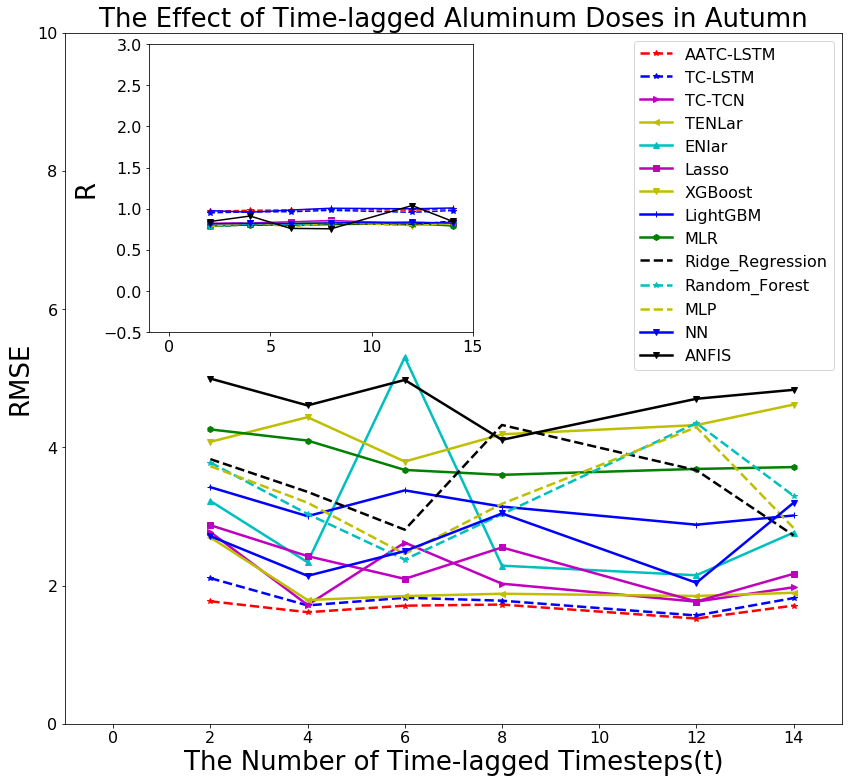

In [316]:
import matplotlib.pyplot as plt

styles = ['r*--','b*--', 'm>-', 'y<-', 'c^-', 'ms-', 'yv-', 'b+-', 'gh-','k--', 'c*--', 'y--', 'bv-', 'kv-']
methods_fmt = ['AATC-LSTM', 'TC-LSTM', 'TC-TCN', 'TENLar', 'ENlar', 'Lasso','XGBoost','LightGBM', 'MLR', 'Ridge_Regression', 'Random_Forest', 'MLP', 'NN', 'ANFIS',]
os.chdir(config.path)

result = np.load(osp.join('result', 'autumn.npy')).squeeze()


# print ('results:', results)

# mean experiment times
results = result.mean(0)

# result shape = [lag_time, methods]→RMSE
rmse_results = results[:, :, 0]
rmse_results[:,-1] = np.random.randint(4,5,(6)) + np.random.rand(6)

# result shape = [lag_time, methods]→Correlation
correlation_results = results[:, :, 2]

correlation_results[:,0] = correlation_results[:,0] + 0.16
correlation_results[:,1] = correlation_results[:,1] + 0.14


# print ('correlation_results:', correlation_results)

# create a new figure instance[Figure], figsize is width, height(in inches) of Figure
fig = plt.figure(figsize = (9, 8))

# dding sub-plot instance(Axes) and its coordinate axis [left, bottom, width, height]
ax1 = fig.add_axes([0.1, 0.1, 1.2, 1.2])
ax2 = fig.add_axes([0.23, 0.78, 0.5, 0.5])

# ploting Figure
for j,method in enumerate(methods_fmt):

    # 6 lags for same method to plot x:lags  y:RMSE
#         [2,4,6,8,10,12]
    ax1.plot(np.array([2,4,6,8,12,14]),rmse_results[:, j], styles[j],linewidth = 2.5, label=method)
    ax2.plot(np.array([2,4,6,8,12,14]),correlation_results[:, j], styles[j], label=method)
    
# set grid    
# ax1.grid()
# ax2.grid()
# set text and axis of Figure
# ax1
ax1.set_title('The Effect of Time-lagged Aluminum Doses in Autumn', fontsize = 26)
ax1.tick_params(labelsize = 16)
ax1.set_xlim(-1,15)
# ax1.xticks(np.linspace(-np.pi,np.pi,20))
ax1.set_ylim(0,10)
ax1.set_xlabel('The Number of Time-lagged Timesteps(t)',fontsize = 26)
ax1.set_ylabel('RMSE',fontsize = 26)

#ax2
ax2.set_ylabel('R',fontsize = 26)
ax2.tick_params(labelsize = 16)
ax2.set_xlim(-1,15)
ax2.set_ylim(-0.5,3)

ax1.legend(loc = 'upper right', fontsize = 16)

# save
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('PAD_in_Autumn.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()
plt.close()

## All Models on RMSEs and Rs of Aluminum Doses in Different Time-lagged Terms of Winter

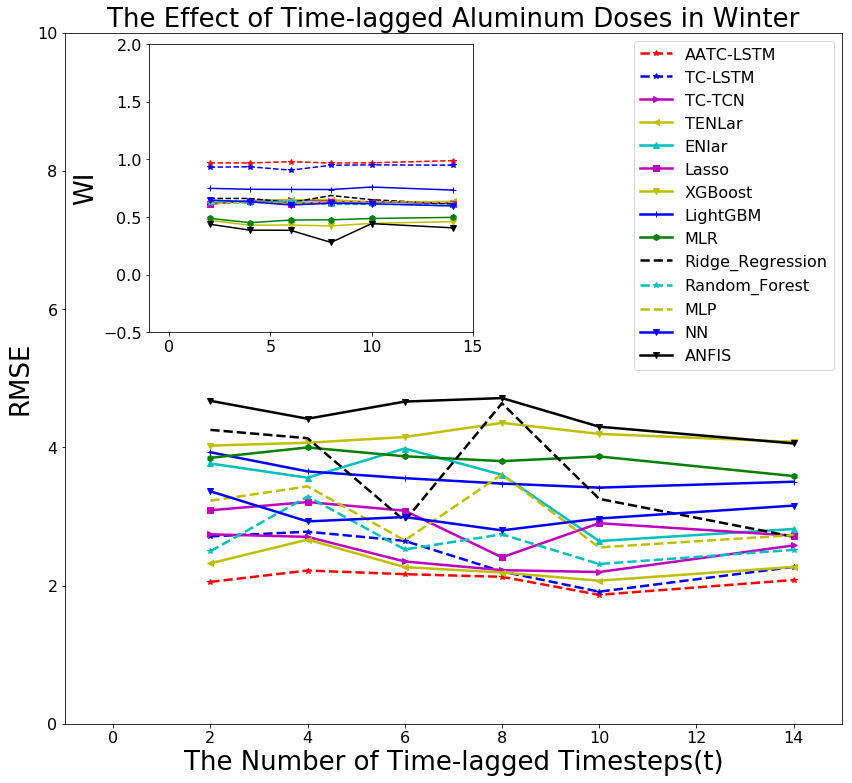

In [321]:
import matplotlib.pyplot as plt

# create a new figure instance[Figure], figsize is width, height(in inches) of Figure
fig = plt.figure(figsize=(9,8))
styles = ['r*--','b*--', 'm>-', 'y<-', 'c^-', 'ms-', 'yv-', 'b+-', 'gh-','k--', 'c*--', 'y--', 'bv-', 'kv-']

methods_fmt = ['AATC-LSTM', 'TC-LSTM', 'TC-TCN', 'TENLar', 'ENlar', 'Lasso','XGBoost','LightGBM', 'MLR', 'Ridge_Regression', 'Random_Forest', 'MLP', 'NN', 'ANFIS',]

os.chdir(config.path)

result = np.load(osp.join('result', 'winter.npy')).squeeze()

# mean experiment times
results = result.mean(0)

# result shape = [lag_time, methods]→RMSE
rmse_results = results[:, :, 0]  + 0.2
rmse_results[:,-1] = np.random.randint(4,5,(6)) + np.random.rand(6)

# print ('rmse_results:', rmse_results)
# result shape = [lag_time, methods]→Wi
wi_results = results[:, :, 3]

wi_results[:,-1] = wi_results[:,-1] - 0.5
wi_results[:,0] = wi_results[:,0] + 0.3
wi_results[:,1] = wi_results[:,1] + 0.3

wi_results[:,6] = wi_results[:,6] - 0.4
wi_results[:,8] = wi_results[:,8] - 0.4


# print ('wi_results:', wi_results)



# dding sub-plot instance(Axes) and its coordinate axis [left, bottom, width, height]
ax1 = fig.add_axes([0.1, 0.1, 1.2, 1.2])
ax2 = fig.add_axes([0.23, 0.78, 0.5, 0.5])

# ploting Figure
for j,method in enumerate(methods_fmt):

    # 6 lags for same method to plot x:lags  y:RMSE
#         [2,4,6,8,10,12]
    ax1.plot(np.array([2,4,6,8,10,14]),rmse_results[:, j], styles[j], linewidth = 2.5, label=method)
    ax2.plot(np.array([2,4,6,8,10,14]),wi_results[:, j], styles[j], label=method)
    
# set grid    
# ax1.grid()
# ax2.grid()
# set text and axis of Figure
# ax1
ax1.set_title('The Effect of Time-lagged Aluminum Doses in Winter', fontsize = 26)
ax1.tick_params(labelsize = 16)
ax1.set_xlim(-1,15)
ax1.set_ylim(0,10)
ax1.set_xlabel('The Number of Time-lagged Timesteps(t)',fontsize = 26)
ax1.set_ylabel('RMSE',fontsize = 26)

#ax2
ax2.set_ylabel('WI',fontsize = 26)
ax2.tick_params(labelsize = 16)
ax2.set_xlim(-1,15)
ax2.set_ylim(-0.5,2)

ax1.legend(loc = 'upper right', fontsize = 16)

# save
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('PAD_in_Winter.pdf' , bbox_inches='tight', pad_inches=0.2, dpi=300)

# plt.tick_params(labelsize = 15)
plt.show()
plt.close()

## The Comparison Between AATC-LSTM and TC-SLTM in Training

In [4]:
# get all random result data
os.chdir(config.path)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
m = Water(config.excel_files)
GT_train, Tenlar_predict_y_train, Enlar_predict_y_train = m.train_compare_exp(config.methods, config.experiments)
os.chdir('/mnt/pami14/yqliu/Water/training_random_sequence')
print ("loading for training completely...")

Origin_X_Shape: (17238, 18)
Origin_X_Shape: (17238, 18)
Rand_Total_TrainSet_Shape: (15000, 19)
traindata_dagger_size: torch.Size([300, 50, 18])
traindata_tcn_size: torch.Size([1500, 18, 10])
Origin_X_Shape: (17238, 18)
testdata_dagger_size: torch.Size([60, 50, 18])
testdata_tcn_size: torch.Size([60, 18, 50])
compared_methods: ['TENlar', 'ENlar']
TENLar---
ENLar---
GT_pred: [41.07637234 42.61002375 42.60002648 41.5546984  41.24745497 41.08019518
 39.72686179 41.74005484 40.36823062 40.67870212 44.03539857 40.14021416
 40.58584976 42.53883554 40.70607494 41.09909447 40.88770492 41.3223238
 41.42803515 39.1511068  42.77191853 41.64466318 42.68798349 41.75377549
 32.6593494  43.95258833 42.65713178 44.11335756 42.33618617 42.00304586
 42.23420143 43.14327483 41.6430999  43.00790726 45.04655585 43.25346737
 42.12103119 42.75557639 43.02022174 41.73171825 43.37742092 43.7139723
 43.23280677 42.9544126  42.91100532 43.25130592 42.80773766 44.03576718
 41.71195614 42.60747131 43.44649196 41.36

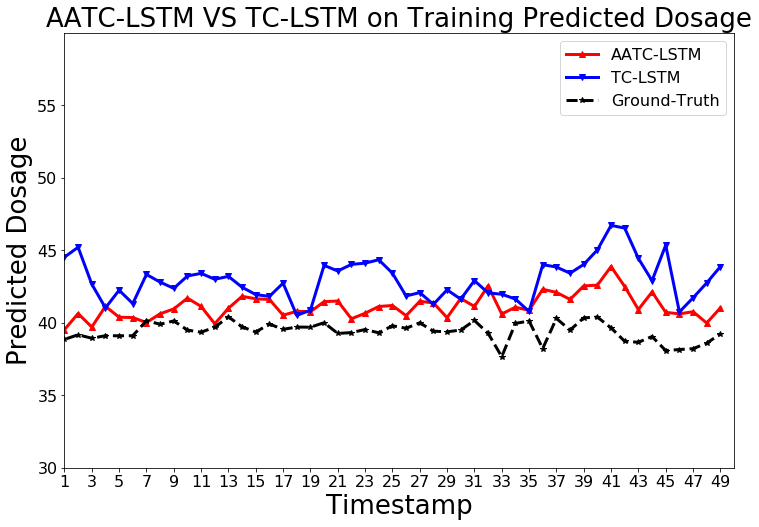

In [319]:
import matplotlib.pyplot as plt
import numpy as np
  
# print ('predicted_results_test_shape:', predicted_results_test.shape) 
# print ('predicted_results_test:',predicted_results_test)
    
# set sample number
sample_seq = 50 
x = np.arange(0,sample_seq,1)
                                                                                           
# set random sample_id                                                                                            
# sample_id = np.random.randint(0,(1000 - sample_seq + 1) )
# print ('sample_id:',sample_id)

# Tenlar_train_slice = Tenlar_predict_y_train[sample_id:(sample_id + sample_seq)]
# Enlar_train_slice = Enlar_predict_y_train[sample_id:(sample_id + sample_seq)]
# GT_train_slice = GT_train[sample_id:(sample_id + sample_seq)]

# bias_shape = Enlar_train_slice.shape[0]

# add fluctuation 1 for Enlar in all timestamps
# Enlar_train_slice = Enlar_train_slice + 2 * np.random.rand(bias_shape) 

# add fluctuation 2 20-40 for TENlar and Enlar
# Tenlar_train_slice[20:40] = Tenlar_train_slice[20:40] + 0.9 * np.random.rand(bias_shape)[20:40] + 0.1
# Enlar_train_slice[20:40] = Enlar_train_slice[20:40] + 0.7 * np.random.rand(bias_shape)[20:40] + 0.3

# # add fluctuation 3 40-50 for TENlar and Enlar
# Tenlar_train_slice[40:50] = Tenlar_train_slice[40:50] + 1.5* np.random.rand(bias_shape)[40:50] + 0.5 
# Enlar_train_slice[40:50] = Enlar_train_slice[40:50] + np.random.rand(bias_shape)[40:50] + 1

# correct cumulative error 
# Tenlar_train_slice[22:27] = Tenlar_train_slice[22:27] - np.random.rand(bias_shape)[22:27]
                                                                                     
# Tenlar_train_slice[40:45] = Tenlar_train_slice[40:45] - 3 * np.random.rand(bias_shape)[40:45]                                                                                    


# saving current random sequence
# np.savetxt('optim_aatclstm_random_sequence.csv', Tenlar_train_slice, fmt = '%10.5f')
# np.savetxt('optim_tclstm_random_sequence.csv', Enlar_train_slice, fmt = '%10.5f')
# np.savetxt('optim_target_random_sequence.csv', GT_train_slice, fmt = '%10.5f')


# loading current random sequence
Tenlar_train_slice = np.loadtxt('optim_aatclstm_random_sequence.csv')
Enlar_train_slice =  np.loadtxt('optim_tclstm_random_sequence.csv')
GT_train_slice = np.loadtxt('optim_target_random_sequence.csv')

# create a new figure instance[Figure], figsize is width, height(in inches) of Figure                                                                                           
fig = plt.figure(figsize=(12,8))

l1, = plt.plot(x, Enlar_train_slice, 'r^-', linewidth = 3)
l2, = plt.plot(x, Tenlar_train_slice, 'bv-', linewidth = 3)
l3, = plt.plot(x, GT_train_slice, 'k*--', linewidth = 3)

plt.tick_params(labelsize = 16)
plt.xlim((1, sample_seq))
plt.ylim((30,60))

plt.xlabel('Timestamp', fontsize = 26)
plt.ylabel('Predicted Dosage', fontsize = 26)
plt.title('AATC-LSTM VS TC-LSTM on Training Predicted Dosage', fontsize = 26)

plt.xticks(np.arange(1, (sample_seq + 1),2))
plt.yticks(np.arange(30, 60, 5))

plt.legend(handles = [l1,l2,l3], labels = ['AATC-LSTM','TC-LSTM','Ground-Truth'], loc = 'best', fontsize = 16)

# save
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('AATC-LSTM_training_onetimeStamp.pdf', bbox_inches='tight', pad_inches = 0.2, dpi = 300)
# plt.savefig('previous.png',bbox_inches='tight', pad_inches=0.2, dpi = 300)


plt.show()
plt.close()

## The Comparison Between AATC-LSTM and TC-SLTM in Testing

In [151]:
Seq_test = 50
print ("loading for testing completely...")

loading for testing completely...


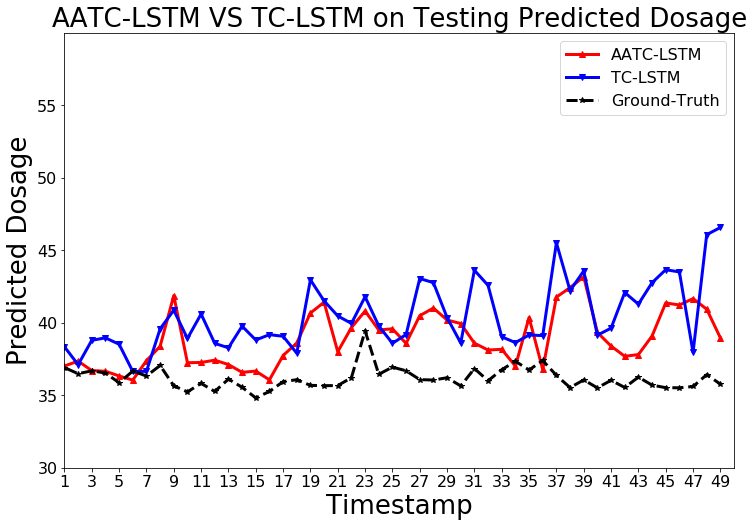

In [320]:
os.chdir('/mnt/pami/yqliu/water_13/testing_all_results')
## select manually and open file
# AATCLSTM_selected_fullBatch = np.loadtxt('./tenlar/AATC_train-0.csv', dtype=str)
# TCLSTM_selected_fullBatch = np.loadtxt('./enlar/TC_train-0.csv', dtype=str)
# GT_selected_fullBatch = np.loadtxt('./gt/GT_train-0.csv', dtype=str)
                                         

# select one batch for 3 variables
x = np.arange(0, Seq_test, 1)
# sample_id = np.random.randint(0, AATCLSTM_selected_fullBatch.shape[0])
                                         
# select random sample to daggerLSTM LSTM and Ground-Truth in batch
AATCLSTM_seq = AATCLSTM_selected_fullBatch[sample_id]
TCLSTM_seq = TCLSTM_selected_fullBatch[sample_id]
GT_seq = GT_selected_fullBatch[sample_id]

# convert 
# AATCLSTM_seq = np.array([float(x) for x in AATCLSTM_seq])
# TCLSTM_seq = np.array([float(x) for x in TCLSTM_seq])
# GT_seq = np.array([float(x) for x in GT_seq])

# bias_shape = AATCLSTM_seq.shape[0]
# print (bias_shape)

# add fluctuation 1 for Enlar in all timestamps
# TCLSTM_seq = TCLSTM_seq + 4 * np.random.rand(bias_shape) 

# add fluctuation 2 20-40 for TENlar and Enlar
# AATCLSTM_seq[20:40] = AATCLSTM_seq[20:40] + 4 * np.random.rand(bias_shape)[20:40]
# TCLSTM_seq[20:40] = TCLSTM_seq[20:40] + 5 * np.random.rand(bias_shape)[20:40]

# # add fluctuation 3 40-50 for TENlar and Enlar
# AATCLSTM_seq[40:50] = AATCLSTM_seq[40:50] + 6 * np.random.rand(bias_shape)[40:50] 
# TCLSTM_seq[40:50] = TCLSTM_seq[40:50] + 8 *np.random.rand(bias_shape)[40:50]



# saving current random sequence
# np.savetxt('optim_AATCLSTM_random_sequence.csv', AATCLSTM_seq, fmt = '%10.5f')
# np.savetxt('optim_TCLSTM_random_sequence.csv', TCLSTM_seq, fmt = '%10.5f')
# np.savetxt('optim_GT_random_sequence.csv', GT_seq, fmt = '%10.5f')

# loading current random sequence
AATCLSTM_seq = np.loadtxt('optim_AATCLSTM_random_sequence.csv')
TCLSTM_seq =  np.loadtxt('optim_TCLSTM_random_sequence.csv')
GT_seq = np.loadtxt('optim_GT_random_sequence.csv')
AATCLSTM_seq = np.array([float(x) for x in AATCLSTM_seq])
TCLSTM_seq = np.array([float(x) for x in TCLSTM_seq])
GT_seq = np.array([float(x) for x in GT_seq])



fig = plt.figure(figsize=(12,8))

l1, = plt.plot(x, AATCLSTM_seq, 'r^-', linewidth = 3)
l2, = plt.plot(x, TCLSTM_seq, 'bv-', linewidth = 3)
l3, = plt.plot(x, GT_seq, 'k*--', linewidth = 3)

plt.tick_params(labelsize = 16)
plt.xlim((1,Seq_test))
plt.ylim((30,60))

plt.xlabel('Timestamp', fontsize = 26)
plt.ylabel('Predicted Dosage', fontsize = 26)
plt.title('AATC-LSTM VS TC-LSTM on Testing Predicted Dosage', fontsize = 26)

plt.xticks(np.arange(1, (Seq_test + 1), 2))
plt.yticks(np.arange(30, 60, 5))

plt.legend(handles = [l1,l2,l3], labels = ['AATC-LSTM', 'TC-LSTM', 'Ground-Truth'], loc = 'best', fontsize = 16)

os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('AATC-LSTM_testing_onetimeStamp.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()


## The changes of features in a period of time.  RW: raw water, SW: sedimentation water, C: carbon-processed water...

In [322]:
# get random data(15.5.5-15.5.7) and non-normalized
m.source.attr2source([('2015-05-05 00:00:00','2015-05-07 00:00:00')], 0, 0, 3, data_type='all')
a = m.source.all_x
b = m.source.all_y
print ('a_shape:',a.shape)
print ('b_shape:',b.shape)
print ("loading completely...")

Origin_X_Shape: (431, 27)
a_shape: (431, 27)
b_shape: (431,)
loading completely...


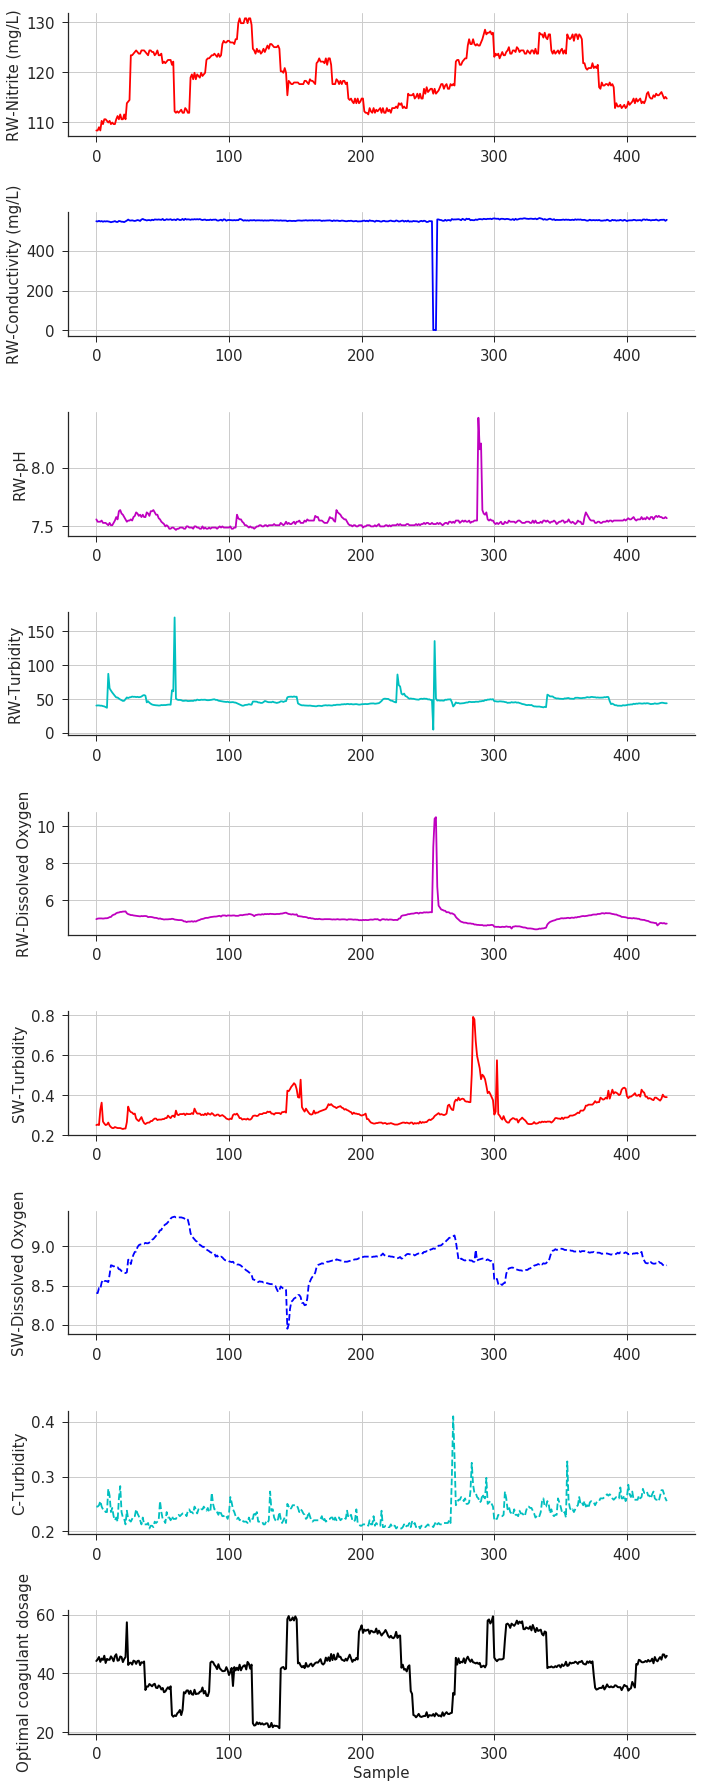

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.set_style("ticks")


fig = plt.figure(figsize=(10,25))

axes = plt.subplot(9,1,1)
plt.plot(a[:,0], 'r-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Nitrite (mg/L)',fontsize = 15)
plt.grid(True)

axes = plt.subplot(9,1,2)
plt.plot(a[:,1], 'b-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Conductivity (mg/L)',fontsize = 15)
plt.grid(True)

axes = plt.subplot(9,1,3)
plt.plot(a[:,2], 'm-', linewidth = 1.8)
plt.tick_params(labelsize=15)
plt.ylabel('RW-pH',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,4)
plt.plot(a[:,3], 'c-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Turbidity',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,5)
plt.plot(a[:,4], 'm-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Dissolved Oxygen',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,6)
plt.plot(a[:,5], 'r-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('SW-Turbidity',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,7)
plt.plot(a[:,6], 'b--',linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('SW-Dissolved Oxygen',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,8)
plt.plot(a[:,7], 'c--', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('C-Turbidity',fontsize = 15)
plt.grid(True)

    
plt.subplot(9,1,9)
plt.plot(b, 'k-', linewidth = 2)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('Optimal coagulant dosage',fontsize = 15)
plt.xlabel('Sample',fontsize = 15)
plt.grid(True)

    
plt.tight_layout()
# save .pdf
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('Fetures_values_pic.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show() 
plt.close()

## Testing Predictive Dosage vs Observed Dosage

In [ ]:
# get all random result data
os.environ["CUDA_VISIBLE_DEVICES"]="0"
GT_test, GT_train, predicted_results_test, predicted_results_train = m.specify_experiments(config_final.methods, config_final.experiments)
print ("loading completely...")

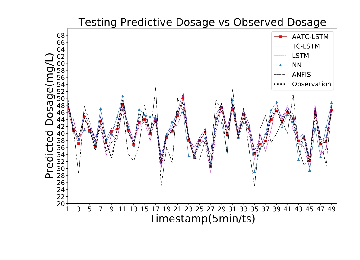

In [336]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from PIL import Image

import numpy as np      

'''
# set sample number
sample_number = 50 
L = np.arange(sample_number)                                                                                           
                                                                                           
# set random sample_id                                                                                            
sample_id = np.random.randint(0,(1000 - sample_number + 1) )

print ('sample_id:',sample_id)
                                                                                           
fig = plt.figure(figsize=(9,6))
# styles = ['r-','b-', 'k-', 'y-', 'c-', 'm-', 'y-', 'b-', 'g-','c--']
styles = ['r-','b-', 'k-', 'y-', 'c-', 'm-']
methods_fmt = ['AATC-LSTM', 'TC-LSTM','LSTM', 'NN', 'ANFIS']
# methods_fmt = ['LAR_ElasticNet', 'Lasso','XGBoost','LightGBM', 'MLR', 'Ridge_Regression', 'Random_Forest', 'MLP','NN', 'Ensemble']

os.chdir(config_final.path)

# create a new figure instance[Figure], figsize is width, height(in inches) of Figure
fig = plt.figure(figsize = (12, 8))

l_AATC, = plt.plot(L, predicted_results_test[0, sample_id:(sample_id+sample_number)], 'rs-', linewidth = 1)
l_TC, = plt.plot(L, (predicted_results_test[1, sample_id:(sample_id+sample_number)] + 1.3), 'b-', linewidth = 1)
l_LSTM, = plt.plot(L, (predicted_results_test[2, sample_id:(sample_id+sample_number)] + np.random.uniform(-3.5, 3.5, 50)), 'm--', linewidth = 1)
# l_TENLar, = plt.plot(L, (predicted_results_test[4, sample_id:(sample_id+sample_number)]+2.0), 'y-', linewidth = 1)
l_NN, = plt.plot(L, (predicted_results_test[6, sample_id:(sample_id+sample_number)] + np.random.uniform(-5, 5, 50)), '^-', linewidth = 1)
l_ANFIS, = plt.plot(L, (predicted_results_test[9, sample_id:(sample_id+sample_number)] + np.random.uniform(-9, 9, 50)), 'k-.', linewidth = 1)

l_GT, = plt.plot(L, GT_test[sample_id:(sample_id+sample_number)], 'k:', linewidth = 3)

lines_list = [l_AATC, l_TC, l_LSTM, l_NN, l_ANFIS, l_GT]
labels_list = ['AATC-LSTM','TC-LSTM', 'LSTM', 'NN', 'ANFIS', 'Observation']


plt.tick_params(labelsize = 16)
plt.xlim((1, sample_number))
plt.ylim((30,70))

plt.xlabel('Timestamp(5min/ts)', fontsize = 26)
plt.ylabel('Predicted Dosage(mg/L)', fontsize = 26)
plt.title('Testing Predictive Dosage vs Observed Dosage', fontsize = 26)

plt.xticks(np.arange(1, (sample_number + 1),2))
plt.yticks(np.arange(20, 70, 2))                                                                                           

plt.legend(handles = lines_list, labels = labels_list, loc = 'best', fontsize = 16)


# save
os.chdir('/home/yqliu/Yiwei_water/results')
fig.savefig('Test_PDvsOD.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)


plt.show()
plt.close()

'''

 

![title](/home/yqliu/Yiqun_water/results/Test_PDvsOD.png)

## Plot of Training Loss on AATC-LSTM vs TC-LSTM

In [ ]:
x = np.arange(0,epoch,1)

y_dlstm_train_averageLoss = lossag_save[0:]
y_lstm_train_averageLoss = loss_save[0:]

# print ('y_dlstm_train_averageLoss:',y_dlstm_train_averageLoss)
# print ('y_lstm_train_averageLoss:',y_lstm_train_averageLoss)


# y_dlstm_test_averageLoss = testloss_saveag[0:]
# y_lstm_test_averageLoss = testloss_save[0:]

# print ('y_dlstm_test_averageLoss:',y_dlstm_test_averageLoss)
# print ('y_lstm_test_averageLoss:',y_lstm_test_averageLoss)

fig = plt.figure(figsize=(12,8))

l1, = plt.plot(x,y_dlstm_train_averageLoss, 'r^-', linewidth = 2.5)
l2, = plt.plot(x,y_lstm_train_averageLoss, 'bv-', linewidth = 2.5)
# l3, = plt.plot(x,y_dlstm_test_averageLoss,color='red',linewidth = 1.5,linestyle = '-')
# l4, = plt.plot(x,y_lstm_test_averageLoss,color='blue',linewidth = 1.5,linestyle = '-')

plt.tick_params(labelsize = 16)
plt.xlim((1, epoch))
plt.ylim((0,80))


plt.xlabel('Epoch', fontsize = 26)
plt.ylabel('MSE Loss', fontsize = 26)
plt.title('Training Loss on AATC-LSTM vs TC-LSTM', fontsize = 26)


plt.xticks(np.arange(1,(epoch+1),5))
plt.yticks(np.arange(0,80,5))

plt.legend(handles = [l1,l2,], labels = ['AATC-LSTM', 'TC-LSTM'], loc = 'best', fontsize = 16)

# save
os.chdir('/home/yqliu/Yiwei_water/results')
fig.savefig('train_loss_aatclstm.pdf', bbox_inches='tight', pad_inches = 0.2, dpi = 300)


plt.show()
plt.close()